In [ ]:
#!pip install statsmodels

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from adjustText import adjust_text
import math
#import warnings
#warnings.filterwarnings('ignore')

# fit the value-based decision model
from scipy.optimize import minimize
from scipy.special import softmax

from sklearn.model_selection import LeaveOneOut
from random import sample
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random

# Load Data

In [2]:
# Task 1 data
data_decisions = pd.read_csv('data/Task1_Final.csv')
data_decisions = data_decisions.drop(columns = ['Mean','SD','ValidS'],axis=1)
survey1_raw = pd.read_csv('data/Survey1_full.csv',skiprows=[1,2])
# Task 2 data
data_ratings = pd.read_csv('output/Task2_scenario_ratings_AC_Var_Mean.csv',index_col=0)
# Task 2 factors
mot_fa = pd.read_csv('output/Factor_analysis/FA_scores.csv',index_col=0)
data_ratings = data_ratings.merge(mot_fa,left_index=True, right_index=True)

# Reorganize data

Each subject data should have the decision rating, the binarized decision, and the 7 key variables:
1. Cost_S_H
2. Benefit_O_H
3. Benefit_S_H
4. Cost_O_NH
5. Cost_S_NH
6. Empathy
7. Urgency

In [4]:
allvars = data_ratings[['Cost_S_H','Benefit_O_H','Benefit_S_H','Cost_O_NH','Cost_S_NH','Empathy','Urgency']]
allvars = allvars / 4 - 1/4 # recode [1,2,3,4,5] to [0,0.25,0.5,0.75,1]
allvars['F1_Benefit'] = (data_ratings['MR1']-data_ratings['MR1'].min())/(data_ratings['MR1'].max()-data_ratings['MR1'].min())
allvars['F2_Cost'] = (data_ratings['MR2']-data_ratings['MR2'].min())/(data_ratings['MR2'].max()-data_ratings['MR2'].min())
allvars

,Cost_S_H,Benefit_O_H,Benefit_S_H,Cost_O_NH,Cost_S_NH,Empathy,Urgency,F1_Benefit,F2_Cost
S1,0.120000,0.576923,0.442308,0.221154,0.278846,0.653846,0.336538,0.477833,0.007691
S2,0.482143,0.633929,0.437500,0.473214,0.294643,0.481481,0.535714,0.275308,0.716325
S3,0.187500,0.821429,0.491071,0.830357,0.535714,0.776786,0.875000,0.740135,0.415999
S4,0.339286,0.490741,0.330357,0.196429,0.160714,0.410714,0.241071,0.068083,0.394211
S5,0.178571,0.785714,0.526786,0.741071,0.410714,0.785714,0.633929,0.663044,0.367494
...,...,...,...,...,...,...,...,...,...
S96,0.206897,0.724138,0.474138,0.396552,0.293103,0.681034,0.431034,0.510948,0.293052
S97,0.098214,0.696429,0.482143,0.312500,0.303571,0.687500,0.464286,0.563156,0.066176
S98,0.093750,0.450000,0.390000,0.190000,0.210000,0.650000,0.320000,0.239317,0.216362
S99,0.151786,0.939655,0.568966,0.939655,0.620690,0.870690,0.974138,0.939891,0.307431


<Axes: >

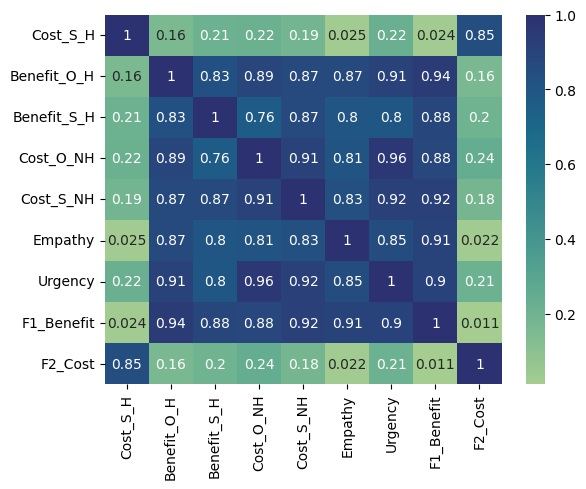

In [5]:
# check the correlations among variables - group level
sns.heatmap(allvars.corr(),annot = True,cmap="crest")

In [6]:
# median of urgency
allvars['Urgency'].median()

0.5672094508301404

In [7]:
# also include the order
order_list = []
for i,row in survey1_raw.iterrows():
    Qorder = row['Willingness-to-help_DO'].split('|')
    Qonly = [f'S{s[1:]}' for s in Qorder if s.startswith('Q')]
    df_order = pd.DataFrame({'order':range(1,51)},index = Qonly)
    order_list.append(df_order)
order_dict = dict(zip(survey1_raw['PROLIFIC_PID'],order_list))

In [8]:
# function to normalize the values trial by trial
def factor_norm_by_time(df):
    F1_min,F1_max,F2_min,F2_max = 0.3,0.7,0.3,0.7
    F1_norm, F2_norm = [],[]
    for i,row in df.iterrows():
        if row['F1_Benefit'] < F1_min:
            F1_min = row['F1_Benefit']
        if row['F1_Benefit'] > F1_max:
            F1_max = row['F1_Benefit']
        if row['F2_Cost'] < F2_min:
            F2_min = row['F2_Cost']
        if row['F2_Cost'] > F2_max:
            F2_max = row['F2_Cost']      
            
        F1_norm.append((row['F1_Benefit']-F1_min)/(F1_max-F1_min))
        F2_norm.append((row['F2_Cost']-F2_min)/(F2_max-F2_min))

    return F1_norm,F2_norm


In [9]:
# the final aggregated data
import warnings

# Disable warnings for this cell
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    data_model = []
    # for each subject
    for row in range(len(data_decisions)):
        willingness = data_decisions.iloc[row,:].dropna()
        ID = willingness['PROLIFIC_PID']
        willingness = willingness.drop('PROLIFIC_PID').transpose()
        willingness = willingness.rename(index=lambda x: 'S' + x[1:])
        data_S = willingness.to_frame(name = 'WTH')
        data_S['WTH'] = pd.to_numeric(data_S['WTH'])
        data_S['Decision'] = (data_S['WTH']>0).astype(int) # binarize the choice
        # merge the rating spreadsheet
        data_S = data_S.join(allvars,how = 'left')
        
        # merge the order
        data_S = data_S.join(order_dict[ID], how = 'left')
        data_S = data_S.dropna()
        # rearrange the datamatrix by actual order
        data_S_sorted = data_S.sort_values(by = 'order')
        # add the order effect column
        data_S_sorted['prev_choice'] = data_S_sorted['Decision'].shift(1) - 0.5
        data_S_sorted['prev_choice'].iloc[0] = 0
    
        # normalize the F1, F2 by order
        F1_norm,F2_norm = factor_norm_by_time(data_S_sorted)
        data_S_sorted['F1_norm'] = F1_norm
        data_S_sorted['F2_norm'] = F2_norm
        
        # append the data to the list
        data_model.append([ID, data_S_sorted])

<Axes: >

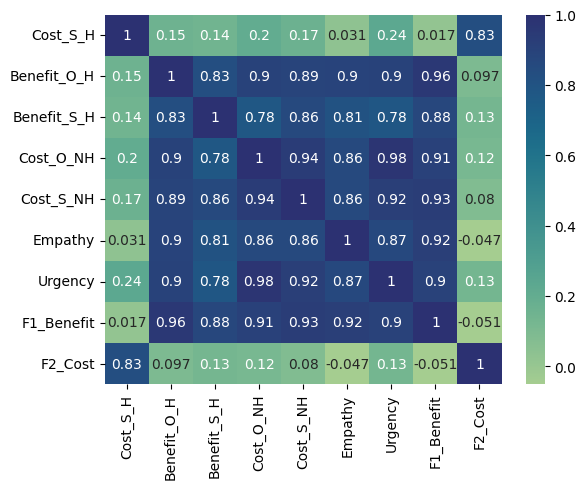

In [10]:
# check the correlations among variable for each subject (average across subject-level correlations)
sum_corr_matrix = None
for each in data_model:
    corrmat = data_S[['Cost_S_H','Benefit_O_H','Benefit_S_H','Cost_O_NH','Cost_S_NH','Empathy','Urgency','F1_Benefit','F2_Cost']].corr()
    if sum_corr_matrix is None:
        sum_corr_matrix = corrmat
    else:
        sum_corr_matrix += corrmat

# Calculate the average correlation matrix
corrmat_avg = sum_corr_matrix / len(data_model)

sns.heatmap(corrmat_avg,annot = True,cmap="crest")

# Value-based Decision Model

## Model fitting functions

In [11]:
def fit_model(df,VBD_model,init_params,param_bounds):
    """
    Fit the model to the data by minimizing the negative log likelihood.
    """
    # Minimize the negative log likelihood
    result = minimize(VBD_model, init_params, args=(df), 
                      method='L-BFGS-B', bounds=param_bounds) 
    
    # Extract fitted parameters
    fitted_params = result.x
    return fitted_params, result.fun


In [12]:
def pseudo_r_squared(fit_llh, df, mode):
    """
    mode 1: McFadden's pseudo R-squared for the model
    mode 2: null model is all 0.5
    """
    epsilon = 1e-5 # prevent underflow
    
    # Null model
    choices = df['Decision'].dropna()
    if mode == 1:
        # 1. fixed choice as baseline
        p = np.mean(choices)  # Mean probability of choosing 1
        null_llh = np.sum(choices * np.log(p + epsilon) + (1 - choices) * np.log(1 - p + epsilon))
    else:
        # 2. 0.5 probability as baseline
        null_llh = np.log(0.5)*len(df.dropna())
        # Calculate McFadden's pseudo R-squared
        r_squared = 1 - (fit_llh / null_llh)
    
    return r_squared


In [13]:
def info_criteria(fit_llh,k,df):
    """
    AIC and BIC
    fit_llh: the loglikelihood (not negative)
    k: number of parameters
    """
    AIC = 2*k - 2*fit_llh

    n = len(df.dropna())
    BIC = np.log(n)*k - 2*fit_llh

    return AIC,BIC
    

In [14]:
def fit_alldata(data_all,VBD_model,init_params,param_bounds,param_names,fit_model,cross_val,gen_model):
    """
    Fit all participant data in the dataset, and output fitting summaries.
    data_all: list of data files, each element is [ID, datamatrix]
    VBD_model: the main model function
    init_params: parameter initialization value
    param_bounds: parameter boundings
    param_names: name of parameters
    fit_model: the function called 'fit_model'
    cross_val: whether apply cross validation, if apply, True
    gen_model: the sample generator model
    """
    
    r_squared = []
    params_all = []
    llh_all = []
    AIC_all = []
    BIC_all = []
    
    for each in data_all:
        fitted_params, neg_log_likelihood = fit_model(each[1],VBD_model,init_params,param_bounds)
        params_all.append(fitted_params)
        llh_all.append(neg_log_likelihood)
        r_squared.append(pseudo_r_squared(-neg_log_likelihood, each[1],2))
        AIC,BIC = info_criteria(-neg_log_likelihood,len(fitted_params),each[1])
        AIC_all.append(AIC)
        BIC_all.append(BIC)

    params_array = np.asarray(params_all)
    model_fit_df = pd.DataFrame({
        'ID': data_decisions['PROLIFIC_PID'],
        'neg_llh': llh_all,
        'r2':r_squared,
        'AIC':AIC_all,
        'BIC':BIC_all,
    })
    for i,parname in enumerate(param_names):
        model_fit_df[parname] = params_array[:, i]


    # cross-validation
    if cross_val == True:
        pred_allsub_df,test_acc_all = LOO_cross_validate(data_model, VBD_model, init_params, param_bounds, param_names, fit_model, gen_model)
        model_fit_df['test_acc'] = test_acc_all
    else:
        pred_allsub_df = None

    return pred_allsub_df,model_fit_df

In [15]:

def LOO_cross_validate(data_all, VBD_model, init_params, param_bounds, param_names, fit_model, gen_model):
    """
    Perform cross validation and get out-of-sample prediction accuracy as a model comparison measure.
    Leave-one-out cross validation 
    """
    test_acc_all = np.full(len(data_all),np.nan)
    pred_allsub_df = None
    for i,each in enumerate(data_all):
        if i % 20 == 19:
            print(i)
        loo = LeaveOneOut()
        data_sub = each[1]
        loo.get_n_splits(data_sub)
        pred_list = np.full(len(data_sub),np.nan)
        # loop over all the k folds
        for j, (train_index, test_index) in enumerate(loo.split(data_sub)):
            data_train = data_sub.iloc[train_index,:]
            data_test = data_sub.iloc[test_index,:]
            fitted_params, neg_log_likelihood = fit_model(data_train,VBD_model,init_params,param_bounds)
            choices, pred_list[test_index] = gen_model(fitted_params, data_test)
        # save the predictions
        data_sub['Pred_choice'] = pred_list
        data_sub['ID'] = each[0]
        data_sub = data_sub.reset_index(names = 'Scenario')

        # initiate the final output dataset
        if pred_allsub_df is None:
            pred_allsub_df = data_sub
        else:
            pred_allsub_df = pd.concat([pred_allsub_df,data_sub],axis=0)
                
        test_acc_all[i]=np.mean(1*(data_sub.dropna()['Pred_choice'] == data_sub.dropna()['Decision']).values)

    return pred_allsub_df,test_acc_all

## VBD Models

### VBD_M1: full model

V_help = *w_self*\*(Benefit_S_H - *w_loss*\*Cost_S_H) + (1-*w_self*)*(Benefit_O_H - *w_loss*\*0)  
V_nohelp = *w_self*\*(0 - *w_loss*\*Cost_S_NH) + (1-*w_self*)\*(0 - *w_loss*\*Cost_O_NH)  
thres = *b* + *w_empathy*\*Empathy + *w_urgency*\*Urgency  
AV(help) = V_help - V_nohelp - thres

In [18]:
def VBD_M1(params,df):
    """
    Value-based decision model - full model
    - Parameters: w_self, w_loss, b, w_empathy, w_urgency, beta
    - Known variables: Benefit_S_H, Cost_S_H, Benefit_O_H, Cost_S_NH, Cost_O_NH, Empathy, Urgency
    - Output: the probability of help
    """
    # extract parameters
    w_self, w_loss, b, w_empathy, w_urgency, beta = params
    epsilon = 1e-5 # prevent underflow
    # compute the value signal
    Value_Help = w_self * (df['Benefit_S_H'] - w_loss * df['Cost_S_H']) + (1 - w_self) * df['Benefit_O_H']
    Value_NoHelp = w_self * (-w_loss * df['Cost_S_NH']) + (1-w_self) * (-w_loss*df['Cost_O_NH'])
    # threshold
    thres = b + w_empathy*df['Empathy'] + w_urgency*df['Urgency']
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # log likelihood
    choices = df['Decision']
    log_likelihood = np.sum(choices * np.log(P_Help + epsilon) + (1 - choices) * np.log(1 - P_Help + epsilon))

    return -log_likelihood


In [19]:
def genchoice_VBD_M1(params,df):
    # extract parameters
    w_self, w_loss, b, w_empathy, w_urgency, beta = params
    # compute the value signal
    Value_Help = w_self * (df['Benefit_S_H'] - w_loss * df['Cost_S_H']) + (1 - w_self) * df['Benefit_O_H']
    Value_NoHelp = w_self * (-w_loss * df['Cost_S_NH']) + (1-w_self) * (-w_loss*df['Cost_O_NH'])
    # threshold
    thres = b + w_empathy*df['Empathy'] + w_urgency*df['Urgency']
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # generate random choices
    choices = []
    for p in P_Help:
        choices.append(random.choices([0, 1], weights=[1-p, p], k=1)[0])

    return choices

### VBD_M2: simple (self cost, other benefit) model + intercept  
AV(help) = w_self(-Cost_S_H) + (1-w_self)*(Benefit_O_H) + b

In [20]:
def VBD_M2(params,df):
    """
    Value-based decision model - simple (self cost, other benefit) model
    - Parameters: w_self, b, beta
    - Known variables: Benefit_O_H, Cost_S_H
    - Output: the probability of help
    """
    # extract parameters
    w_self, b,  beta = params
    epsilon = 1e-5 # prevent underflow
    # compute the value signal
    Value_Help = - w_self * (df['Cost_S_H']) + (1 - w_self) * df['Benefit_O_H']
    Value_NoHelp = 0
    # threshold
    thres = b
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # log likelihood
    choices = df['Decision']
    log_likelihood = np.sum(choices * np.log(P_Help + epsilon) + (1 - choices) * np.log(1 - P_Help + epsilon))

    return -log_likelihood


In [21]:
def genchoice_VBD_M2(params,df):
    # extract parameters
    w_self, b, beta = params
    # compute the value signal
    Value_Help = - w_self * (df['Cost_S_H']) + (1 - w_self) * df['Benefit_O_H']
    Value_NoHelp = 0
    # threshold
    thres = b 
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # generate random choices
    choices = []
    # predict choice, use deterministic, if p >-0.5 -> help
    pred = []
    for p in P_Help:
        choices.append(random.choices([0, 1], weights=[1-p, p], k=1)[0])
        pred.append(1*(p >= 0.5))

    return choices, pred

### VBD_M3: simple (cost, reward) model + intercept, using factors  
AV(help) = w_self(-F2_Cost) + (1-w_self)*(F1_Benefit) + b

In [16]:
def VBD_M3(params,df):
    """
    Value-based decision model - simple (cost, benefit) model
    - Parameters: w_cost, b, beta
    - Known variables: Benefit_O_H, Cost_S_H
    - Output: the probability of help
    """
    # extract parameters
    w_cost, b,  beta = params
    epsilon = 1e-5 # prevent underflow
    # compute the value signal
    Value_Help = - w_cost * (df['F2_Cost']) + (1 - w_cost) * df['F1_Benefit']
    Value_NoHelp = 0
    # threshold
    thres = b
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # log likelihood
    choices = df['Decision']
    log_likelihood = np.sum(choices * np.log(P_Help + epsilon) + (1 - choices) * np.log(1 - P_Help + epsilon))

    return -log_likelihood

In [17]:
def genchoice_VBD_M3(params,df):
    # extract parameters
    w_cost, b,  beta = params

    # compute the value signal
    Value_Help = - w_cost * (df['F2_Cost']) + (1 - w_cost) * df['F1_Benefit']
    Value_NoHelp = 0
    # threshold
    thres = b 
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # generate random choices
    choices = []
    # predict choice, use deterministic, if p >-0.5 -> help
    pred = []
    for p in P_Help:
        choices.append(random.choices([0, 1], weights=[1-p, p], k=1)[0])
        pred.append(1*(p >= 0.5))

    return choices, pred

VBD_M3_1: use 2 orthogonal weights for cost and benefit

In [23]:
def VBD_M3_1(params,df):
    """
    Value-based decision model - simple (cost, benefit) model
    - Parameters: w_cost, w_benefit, b, beta
    - Known variables: Benefit_O_H, Cost_S_H
    - Output: the probability of help
    """
    # extract parameters
    w_cost, w_benefit, b,  beta = params
    epsilon = 1e-5 # prevent underflow
    # compute the value signal
    Value_Help = - w_cost * (df['F2_Cost']) + w_benefit * df['F1_Benefit']
    Value_NoHelp = 0
    # threshold
    thres = b
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # log likelihood
    choices = df['Decision']
    log_likelihood = np.sum(choices * np.log(P_Help + epsilon) + (1 - choices) * np.log(1 - P_Help + epsilon))

    return -log_likelihood

In [24]:
def genchoice_VBD_M3_1(params,df):
    # extract parameters
    w_cost, w_benefit, b,  beta = params
    # compute the value signal
    Value_Help = - w_cost * (df['F2_Cost']) + w_benefit * df['F1_Benefit']
    Value_NoHelp = 0
    # threshold
    thres = b 
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # generate random choices
    choices = []
    # predict choice, use deterministic, if p >-0.5 -> help
    pred = []
    for p in P_Help:
        choices.append(random.choices([0, 1], weights=[1-p, p], k=1)[0])
        pred.append(1*(p >= 0.5))

    return choices, pred

VBD_M3_2: use 1 weight, but another nonlinear term alpha on cost.

In [25]:
def VBD_M3_2(params,df):
    """
    Value-based decision model - simple (cost, benefit) model
    - Parameters: w_cost, w_benefit, b, beta
    - Known variables: Benefit_O_H, Cost_S_H
    - Output: the probability of help
    """
    # extract parameters
    w_cost, alpha, b,  beta = params
    epsilon = 1e-5 # prevent underflow
    # compute the value signal
    Value_Help = - w_cost * (df['F2_Cost']**alpha) + (1-w_cost) * df['F1_Benefit']
    Value_NoHelp = 0
    # threshold
    thres = b
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # log likelihood
    choices = df['Decision']
    log_likelihood = np.sum(choices * np.log(P_Help + epsilon) + (1 - choices) * np.log(1 - P_Help + epsilon))

    return -log_likelihood

In [26]:
def genchoice_VBD_M3_2(params,df):
    # extract parameters
    w_cost, alpha, b,  beta = params
    # compute the value signal
    Value_Help = - w_cost * (df['F2_Cost']**alpha) + (1-w_cost) * df['F1_Benefit']
    Value_NoHelp = 0
    # threshold
    thres = b 
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # generate random choices
    choices = []
    # predict choice, use deterministic, if p >-0.5 -> help
    pred = []
    for p in P_Help:
        choices.append(random.choices([0, 1], weights=[1-p, p], k=1)[0])
        pred.append(1*(p >= 0.5))

    return choices, pred

VBD_M3_3: use 1 weight but nonlinear term alpha on benefit

In [27]:
def VBD_M3_3(params,df):
    """
    Value-based decision model - simple (cost, benefit) model
    - Parameters: w_cost, alpha, b, beta
    - Known variables: Benefit_O_H, Cost_S_H
    - Output: the probability of help
    """
    # extract parameters
    w_cost, alpha, b,  beta = params
    epsilon = 1e-5 # prevent underflow
    # compute the value signal
    Value_Help = - w_cost * df['F2_Cost'] + (1-w_cost) * df['F1_Benefit']**alpha
    Value_NoHelp = 0
    # threshold
    thres = b
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # log likelihood
    choices = df['Decision']
    log_likelihood = np.sum(choices * np.log(P_Help + epsilon) + (1 - choices) * np.log(1 - P_Help + epsilon))

    return -log_likelihood

In [28]:
def genchoice_VBD_M3_3(params,df):
    # extract parameters
    w_cost, alpha, b,  beta = params
    # compute the value signal
    Value_Help = - w_cost * df['F2_Cost'] + (1-w_cost) * df['F1_Benefit']**alpha
    Value_NoHelp = 0
    # threshold
    thres = b 
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # generate random choices
    choices = []
    # predict choice, use deterministic, if p >-0.5 -> help
    pred = []
    for p in P_Help:
        choices.append(random.choices([0, 1], weights=[1-p, p], k=1)[0])
        pred.append(1*(p >= 0.5))

    return choices, pred

VBD_M3_4: urgency bonus

In [17]:
def VBD_M3_4(params,df):
    """
    Value-based decision model - simple (cost, benefit) model
    - Parameters: w_cost, alpha, b, beta
    - Known variables: Benefit_O_H, Cost_S_H
    - Output: the probability of help
    """
    # extract parameters
    w_cost, b, w_urgency, beta = params
    epsilon = 1e-5 # prevent underflow
    # compute the value signal
    Value_Help = - w_cost * df['F2_Cost'] + (1-w_cost) * df['F1_Benefit']
    Value_NoHelp = 0
    # threshold
    # urgency binary variable
    urgency = 1*(df['Urgency']>0.567)
    thres = b + w_urgency * urgency
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # log likelihood
    choices = df['Decision']
    log_likelihood = np.sum(choices * np.log(P_Help + epsilon) + (1 - choices) * np.log(1 - P_Help + epsilon))

    return -log_likelihood

In [18]:
def genchoice_VBD_M3_4(params,df):
    # extract parameters
    w_cost, b, w_urgency, beta = params
    # compute the value signal
    Value_Help = - w_cost * df['F2_Cost'] + (1-w_cost) * df['F1_Benefit']
    Value_NoHelp = 0
    # threshold
    # urgency binary variable
    urgency = 1*(df['Urgency']>0.567)
    thres = b + w_urgency * urgency
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # generate random choices
    choices = []
    # predict choice, use deterministic, if p >-0.5 -> help
    pred = []
    for p in P_Help:
        choices.append(random.choices([0, 1], weights=[1-p, p], k=1)[0])
        pred.append(1*(p >= 0.5))

    return choices, pred

VBD_M3_5: use 1 weight but another term apply at cost

In [69]:
def VBD_M3_5(params,df):
    """
    Value-based decision model - simple (cost, benefit) model
    - Parameters: w_cost, alpha, b, beta
    - Known variables: Benefit_O_H, Cost_S_H
    - Output: the probability of help
    """
    # extract parameters
    w_cost, alpha, b,  beta = params
    epsilon = 1e-5 # prevent underflow
    # compute the value signal
    Value_Help = - w_cost *alpha*df['F2_Cost'] + (1-w_cost) * df['F1_Benefit']
    Value_NoHelp = 0
    # threshold
    thres = b
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # log likelihood
    choices = df['Decision']
    log_likelihood = np.sum(choices * np.log(P_Help + epsilon) + (1 - choices) * np.log(1 - P_Help + epsilon))

    return -log_likelihood

### VBD_M4: + interaction term

In [29]:
def VBD_M4(params,df):
    """
    Value-based decision model - simple (cost, benefit) model
    - Parameters: w_cost, b, beta
    - Known variables: Benefit_O_H, Cost_S_H
    - Output: the probability of help
    """
    # extract parameters
    w_cost, w_magnitude, b,  beta = params    
    epsilon = 1e-5 # prevent underflow
    # compute the value signal
    Value_Help = - w_cost * (df['F2_Cost']) + (1 - w_cost) * df['F1_Benefit']
    Value_NoHelp = 0
    # threshold
    thres = b + w_magnitude*df['F2_Cost']*df['F1_Benefit']
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # log likelihood
    choices = df['Decision']
    log_likelihood = np.sum(choices * np.log(P_Help + epsilon) + (1 - choices) * np.log(1 - P_Help + epsilon))

    return -log_likelihood

In [30]:
def genchoice_VBD_M4(params,df):
    # extract parameters
    w_cost, w_magnitude, b,  beta = params
    # compute the value signal
    Value_Help = - w_cost * (df['F2_Cost']) + (1 - w_cost) * df['F1_Benefit']
    Value_NoHelp = 0
    # threshold
    thres = b + w_magnitude*df['F2_Cost']*df['F1_Benefit']
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))

    # generate random choices
    choices = []
    # predict choice, use deterministic, if p >-0.5 -> help
    pred = []
    for p in P_Help:
        choices.append(random.choices([0, 1], weights=[1-p, p], k=1)[0])
        pred.append(1*(p >= 0.5))

    return choices, pred

### VBD_M5: fixed helping propensity model

In [31]:
def VBD_M5(params,df):
    """
    Value-based decision model - fixed value
    - Parameters: b, beta
    - Known variables: NA
    - Output: the probability of help
    """
    # extract parameters
    b,  beta = params
    epsilon = 1e-5 # prevent underflow
    # compute the value signal
    Value_Help = 0
    Value_NoHelp = 0
    # threshold
    thres = b
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))*np.ones(len(df))

    # log likelihood
    choices = df['Decision']
    log_likelihood = np.sum(choices * np.log(P_Help + epsilon) + (1 - choices) * np.log(1 - P_Help + epsilon))

    return -log_likelihood

In [32]:
def genchoice_VBD_M5(params,df):
    # extract parameters
    b,  beta = params
    # compute the value signal
    Value_Help = 0
    Value_NoHelp = 0
    # threshold
    thres = b
    # action value
    AV = Value_Help - Value_NoHelp - thres
    # compute the probability of help
    P_Help = 1/(1 + np.exp(-beta * AV))*np.ones(len(df))

    # generate random choices
    choices = []
    # predict choice, use deterministic, if p >-0.5 -> help
    pred = []
    for p in P_Help:
        choices.append(random.choices([0, 1], weights=[1-p, p], k=1)[0])
        pred.append(1*(p >= 0.5))

    return choices, pred

## Explore different models

### VBD_M1

0.436248656889523


Text(0, 0.5, 'Frequency')

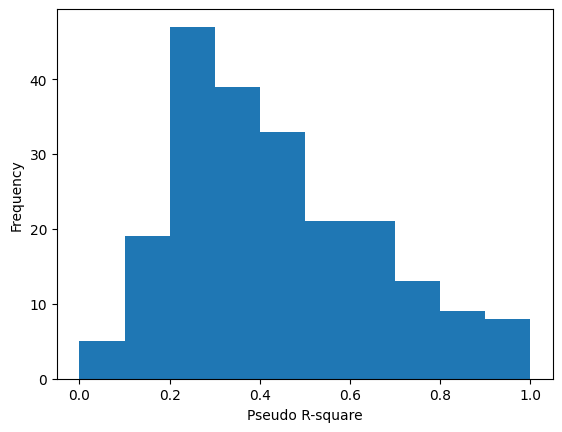

In [38]:
VBD_model = VBD_M1
folder_name = 'VBD_M1'
init_params = np.array([0.8, 1.2, 0.3, -0.4, -0.3, 2])
param_bounds =  [(0, 1), (-10, 10), (-1, 1),(-1, 1), (-1,1),(1e-5,10)]
param_names = ['w_self','w_loss','b','w_empathy','w_urgency','beta']
               
model_fit_m1 = fit_alldata(data_model,VBD_model,init_params,param_bounds,param_names,fit_model)
    
# Save the model output
model_fit_m1.to_csv('output/Model/'+folder_name+'/model_fits.csv',index=False)

# Distribution of pseudo R2
plt.hist(model_fit_m1['r2'])
print(np.mean(model_fit_m1['r2']))
plt.xlabel('Pseudo R-square')
plt.ylabel('Frequency')

### VBD_M2

R2 = 0.385
AIC = 27.246
BIC = 32.982
Out of sample prediction ACC = 0.77


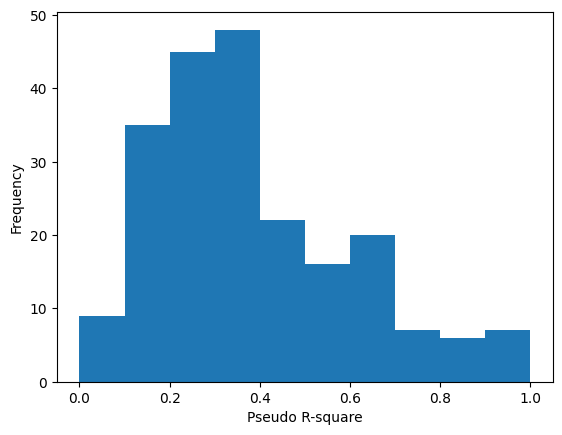

In [28]:
VBD_model = VBD_M2
gen_model = genchoice_VBD_M2
folder_name = 'VBD_M2'
init_params = np.array([0.8, 0.3, 2])
param_bounds =  [(0, 1), (-1,1), (1e-5,10)]
param_names = ['w_self','b','beta']
               
model_fit_m2 = fit_alldata(data_model,VBD_model,init_params,param_bounds,param_names,fit_model,True,gen_model)
    
# Save the model output
model_fit_m2.to_csv('output/Model/'+folder_name+'/model_fits.csv',index=False)

# Distribution of pseudo R2
plt.hist(model_fit_m2['r2'])
plt.xlabel('Pseudo R-square')
plt.ylabel('Frequency')


print(f'R2 = {np.round(np.mean(model_fit_m2['r2']),3)}')
print(f'AIC = {np.round(np.mean(model_fit_m2['AIC']),3)}')
print(f'BIC = {np.round(np.mean(model_fit_m2['BIC']),3)}')
print(f'Out of sample prediction ACC = {np.round(np.mean(model_fit_m2['test_acc']),3)}')

### VBD_M3

**VBD_M3**

R2 = 0.42
AIC = 46.088
BIC = 51.816


KeyError: 'test_acc'

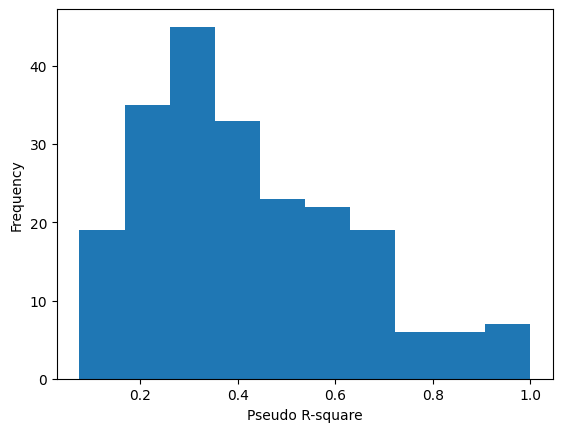

In [35]:
VBD_model = VBD_M3
gen_model = genchoice_VBD_M3
folder_name = 'VBD_M3'
init_params = np.array([-0.8, 0, 2])
param_bounds =  [(0, 1), (-1,1), (1e-5,10)]
param_names = ['w_cost','b','beta']
               
pred_allsub_df_m3, model_fit_m3 = fit_alldata(data_model,VBD_model,init_params,param_bounds,param_names,fit_model,False,gen_model)
    
# Save the model output
model_fit_m3.to_csv('output/Model/'+folder_name+'/model_fits1.csv',index=False)
#pred_allsub_df_m3.to_csv('output/Model/'+folder_name+'/LOO_pred.csv',index=False)

# Distribution of pseudo R2
plt.hist(model_fit_m3['r2'])
plt.xlabel('Pseudo R-square')
plt.ylabel('Frequency')

print(f'R2 = {np.round(np.mean(model_fit_m3['r2']),3)}')
print(f'AIC = {np.round(np.mean(model_fit_m3['AIC']),3)}')
print(f'BIC = {np.round(np.mean(model_fit_m3['BIC']),3)}')
print(f'Out of sample prediction ACC = {np.round(np.mean(model_fit_m3['test_acc']),3)}')

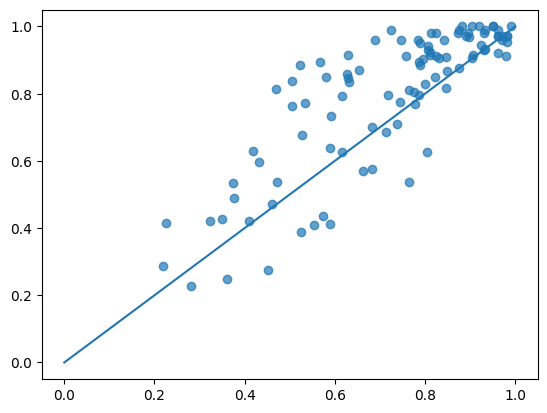

In [81]:
# check the prediction accuracy of scenarios
grouped_means = pred_allsub_df_m3.groupby('Scenario')[['Decision','Pred_choice']].mean()
plt.scatter(grouped_means['Decision'],grouped_means['Pred_choice'],alpha = 0.7)
np.corrcoef(grouped_means['Decision'],grouped_means['Pred_choice'])[0,1]
plt.plot([0,1],[0,1])

**VBD_M3_1**

0.4272169373370903
R2 = 0.427
AIC = 47.582
BIC = 55.219


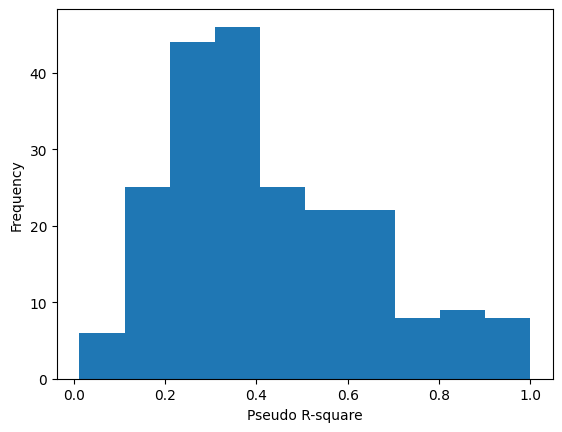

In [36]:
VBD_model = VBD_M3_1
gen_model = genchoice_VBD_M3_1
folder_name = 'VBD_M3_1'
init_params = np.array([0.8, 0.5, 0.3, 2])
param_bounds =  [(-3, 3), (-3,3), (-3,3), (1e-5,10)]
param_names = ['w_cost','w_benefit','b','beta']
               
pred_allsub_df_m3_1, model_fit_m3_1 = fit_alldata(data_model,VBD_model,init_params,param_bounds,param_names,fit_model,False,gen_model)
    
# Save the model output
model_fit_m3_1.to_csv('output/Model/'+folder_name+'/model_fits1.csv',index=False)
#pred_allsub_df_m3_1.to_csv('output/Model/'+folder_name+'/LOO_pred.csv',index=False)

# Distribution of pseudo R2
plt.hist(model_fit_m3_1['r2'])
print(np.mean(model_fit_m3_1['r2']))
plt.xlabel('Pseudo R-square')
plt.ylabel('Frequency')

print(f'R2 = {np.round(np.mean(model_fit_m3_1['r2']),3)}')
print(f'AIC = {np.round(np.mean(model_fit_m3_1['AIC']),3)}')
print(f'BIC = {np.round(np.mean(model_fit_m3_1['BIC']),3)}')
#print(f'Out of sample prediction ACC = {np.round(np.mean(model_fit_m3_1['test_acc']),3)}')

**VBD_M3_2**

0.42160746487374257
R2 = 0.422
AIC = 47.971
BIC = 55.608


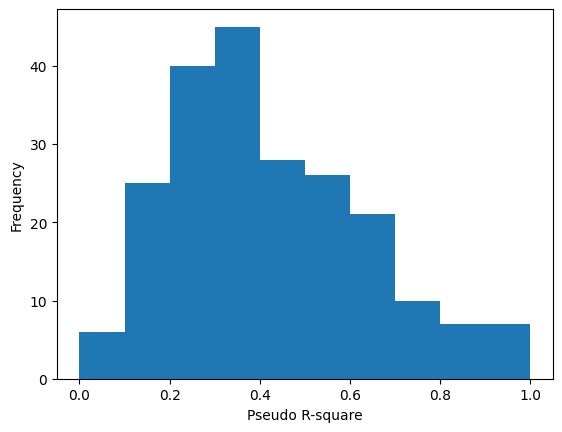

In [37]:
VBD_model = VBD_M3_2
folder_name = 'VBD_M3_2'
init_params = np.array([0.8, 0.5, 0.3, 2])
param_bounds =  [(0, 1), (0,3), (-3,3), (1e-5,10)]
param_names = ['w_cost','alpha','b','beta']
               
pred_allsub_df_m3_2, model_fit_m3_2 = fit_alldata(data_model,VBD_model,init_params,param_bounds,param_names,fit_model,False,gen_model)
    
# Save the model output
model_fit_m3_2.to_csv('output/Model/'+folder_name+'/model_fits1.csv',index=False)
#pred_allsub_df_m3_2.to_csv('output/Model/'+folder_name+'/LOO_pred.csv',index=False)

# Distribution of pseudo R2
plt.hist(model_fit_m3_2['r2'])
print(np.mean(model_fit_m3_2['r2']))
plt.xlabel('Pseudo R-square')
plt.ylabel('Frequency')

print(f'R2 = {np.round(np.mean(model_fit_m3_2['r2']),3)}')
print(f'AIC = {np.round(np.mean(model_fit_m3_2['AIC']),3)}')
print(f'BIC = {np.round(np.mean(model_fit_m3_2['BIC']),3)}')
#print(f'Out of sample prediction ACC = {np.round(np.mean(model_fit_m3_2['test_acc']),3)}')

**VBD_M3_3**

0.41134497255382996
R2 = 0.411
AIC = 48.682
BIC = 56.319


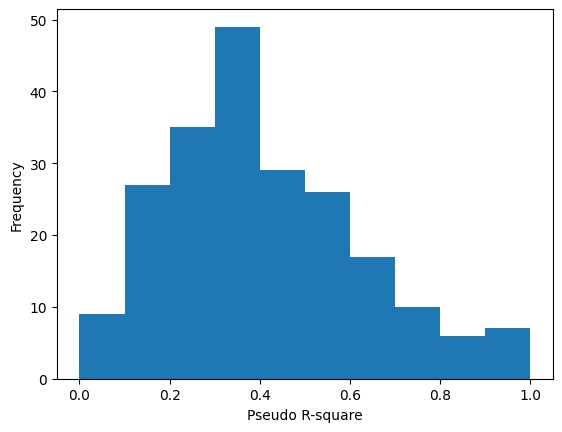

In [38]:
VBD_model = VBD_M3_3
folder_name = 'VBD_M3_3'
init_params = np.array([0.8, 0.5, 0.3, 2])
param_bounds =  [(0, 1), (0,3), (-3,3), (1e-5,10)]
param_names = ['w_cost','alpha','b','beta']
               
pred_allsub_df_m3_3, model_fit_m3_3 = fit_alldata(data_model,VBD_model,init_params,param_bounds,param_names,fit_model,False,gen_model)
    
# Save the model output
model_fit_m3_3.to_csv('output/Model/'+folder_name+'/model_fits1.csv',index=False)
#pred_allsub_df_m3_3.to_csv('output/Model/'+folder_name+'/LOO_pred.csv',index=False)

# Distribution of pseudo R2
plt.hist(model_fit_m3_3['r2'])
print(np.mean(model_fit_m3_3['r2']))
plt.xlabel('Pseudo R-square')
plt.ylabel('Frequency')

print(f'R2 = {np.round(np.mean(model_fit_m3_3['r2']),3)}')
print(f'AIC = {np.round(np.mean(model_fit_m3_3['AIC']),3)}')
print(f'BIC = {np.round(np.mean(model_fit_m3_3['BIC']),3)}')
#print(f'Out of sample prediction ACC = {np.round(np.mean(model_fit_m3_3['test_acc']),3)}')

**VBD_M3_4**

19
39
59
79
99
119
139
159
179
199
R2 = 0.441
AIC = 46.657
BIC = 54.294
Out of sample prediction ACC = 0.787


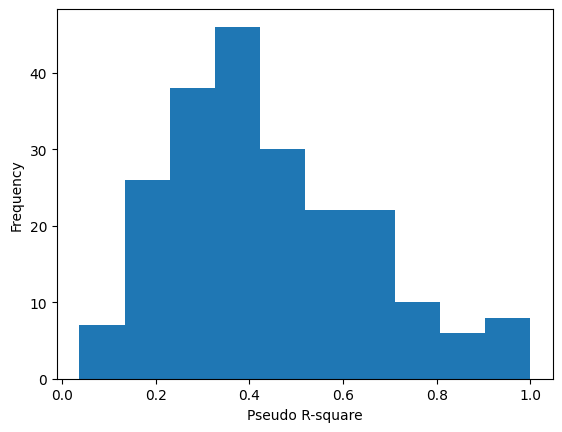

In [19]:
VBD_model = VBD_M3_4
gen_model = genchoice_VBD_M3_4
folder_name = 'VBD_M3_4'
init_params = np.array([0.8, 0.5, 0.3, 2])
param_bounds =  [(0, 1), (-1,1), (-1,1), (1e-5,10)]
param_names = ['w_cost','b','w_urgency','beta']
               
pred_allsub_df_m3_4, model_fit_m3_4 = fit_alldata(data_model,VBD_model,init_params,param_bounds,param_names,fit_model,True,gen_model)
    
# Save the model output
model_fit_m3_4.to_csv('output/Model/'+folder_name+'/model_fits.csv',index=False)
pred_allsub_df_m3_4.to_csv('output/Model/'+folder_name+'/LOO_pred.csv',index=False)

# Distribution of pseudo R2
plt.hist(model_fit_m3_4['r2'])
plt.xlabel('Pseudo R-square')
plt.ylabel('Frequency')
print(f'R2 = {np.round(np.mean(model_fit_m3_4['r2']),3)}')
print(f'AIC = {np.round(np.mean(model_fit_m3_4['AIC']),3)}')
print(f'BIC = {np.round(np.mean(model_fit_m3_4['BIC']),3)}')
print(f'Out of sample prediction ACC = {np.round(np.mean(model_fit_m3_4['test_acc']),3)}')

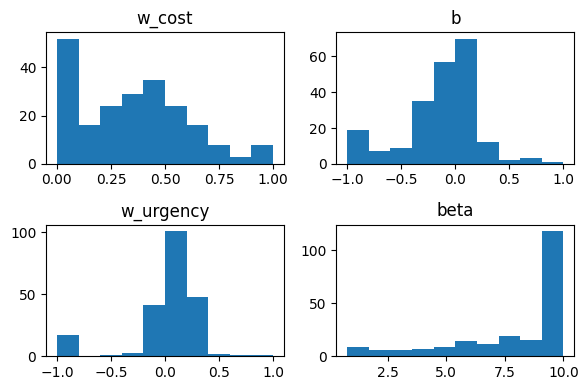

In [68]:
# visualize parameters
n_cols = 2
n_rows = math.ceil(len(param_names)/n_cols)
fig,axes = plt.subplots(n_rows,n_cols,figsize=(6,4))
axes = axes.flatten()
for i,name in enumerate(param_names):
    axes[i].hist(model_fit_m3_4[name])
    axes[i].set_title(name)

plt.tight_layout()
plt.show()

**VBD_M3_5**

0.37784298627815593


Text(0, 0.5, 'Frequency')

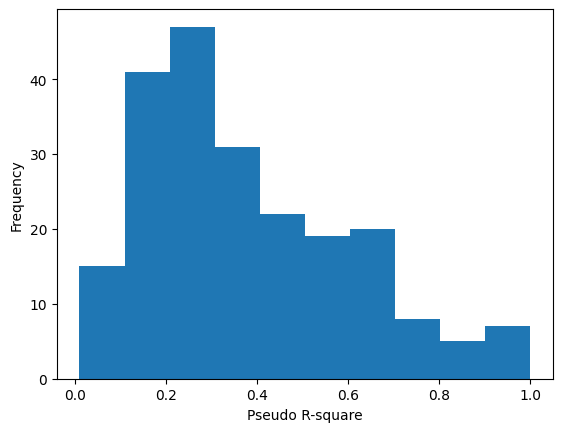

In [70]:
VBD_model = VBD_M3_5
folder_name = 'VBD_M3_5'
init_params = np.array([0.8, 0.5, 0.3, 2])
param_bounds =  [(0, 1), (-3,3), (-1,1),(1e-5,10)]
param_names = ['w_cost','alpha','b','beta']
               
model_fit_m3_5 = fit_alldata(data_model,VBD_model,init_params,param_bounds,param_names,fit_model)
    
# Save the model output
model_fit_m3_5.to_csv('output/Model/'+folder_name+'/model_fits.csv',index=False)

# Distribution of pseudo R2
plt.hist(model_fit_m3_5['r2'])
print(np.mean(model_fit_m3_5['r2']))
plt.xlabel('Pseudo R-square')
plt.ylabel('Frequency')

### VBD_M4

R2 = 0.418
AIC = 48.222
BIC = 55.859


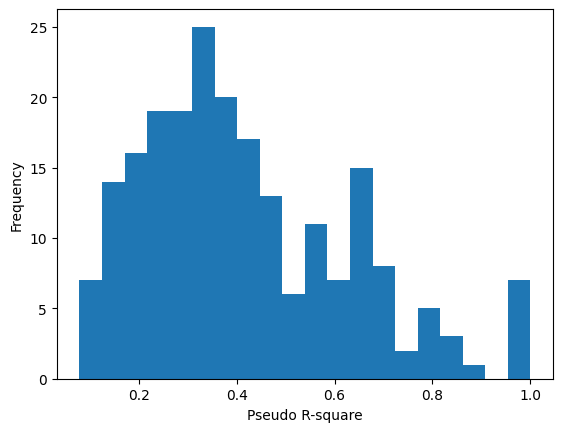

In [39]:
VBD_model = VBD_M4
gen_model = genchoice_VBD_M4
folder_name = 'VBD_M4'
init_params = np.array([0.7,0.5,-0.5,1])
param_bounds =  [(0, 1),(-3,3),(-3,3),(1e-5,10)]
param_names = ['w_self','w_magnitude','b','beta']
               
               
pred_allsub_df_m4, model_fit_m4 = fit_alldata(data_model,VBD_model,init_params,param_bounds,param_names,fit_model,False,gen_model)
    
# Save the model output
model_fit_m4.to_csv('output/Model/'+folder_name+'/model_fits1.csv',index=False)
#pred_allsub_df_m4.to_csv('output/Model/'+folder_name+'/LOO_pred.csv',index=False)


# Distribution of pseudo R2
plt.hist(model_fit_m4['r2'],20)
plt.xlabel('Pseudo R-square')
plt.ylabel('Frequency')
print(f'R2 = {np.round(np.mean(model_fit_m4['r2']),3)}')
print(f'AIC = {np.round(np.mean(model_fit_m4['AIC']),3)}')
print(f'BIC = {np.round(np.mean(model_fit_m4['BIC']),3)}')
#print(f'Out of sample prediction ACC = {np.round(np.mean(model_fit_m4['test_acc']),3)}')

### VBD_M5

R2 = 0.264
AIC = 54.843
BIC = 58.661


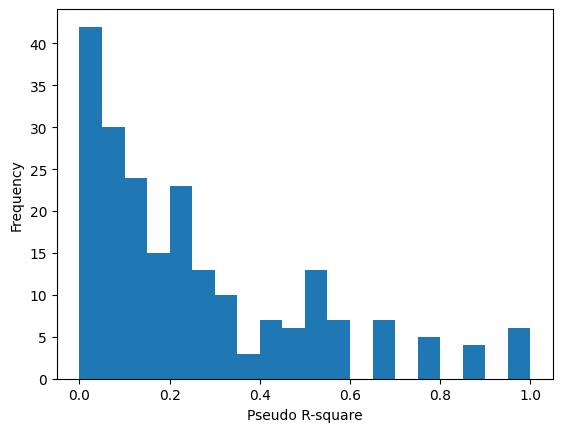

In [40]:
VBD_model = VBD_M5
gen_model = genchoice_VBD_M5
folder_name = 'VBD_M5'
init_params = np.array([0.7,1])
param_bounds =  [(-1, 1), (1e-5,10)]
param_names = ['b','beta']

pred_allsub_df_m5, model_fit_m5 = fit_alldata(data_model,VBD_model,init_params,param_bounds,param_names,fit_model,False,gen_model)
    
# Save the model output
model_fit_m5.to_csv('output/Model/'+folder_name+'/model_fits1.csv',index=False)
#pred_allsub_df_m5.to_csv('output/Model/'+folder_name+'/LOO_pred.csv',index=False)

# Distribution of pseudo R2
plt.hist(model_fit_m5['r2'],20)
plt.xlabel('Pseudo R-square')
plt.ylabel('Frequency')
print(f'R2 = {np.round(np.mean(model_fit_m5['r2']),3)}')
print(f'AIC = {np.round(np.mean(model_fit_m5['AIC']),3)}')
print(f'BIC = {np.round(np.mean(model_fit_m5['BIC']),3)}')
#print(f'Out of sample prediction ACC = {np.round(np.mean(model_fit_m5['test_acc']),3)}')

# Parameter Recovery

## Method 1
randomly sample parameters from uniform distributions

In [37]:
# method 1: randomly sample from the parameter space
params_all = []
for p in range(100):
    beta = np.random.uniform(1,5,1)[0]
    w_cost = np.random.uniform(0,1,1)[0]
    b = np.random.uniform(-1,1,1)[0]
    params_all.append([w_cost,b,beta])

In [38]:
# Simulate data and refit using the model
n_sim = 10 # number of simulations
param_rec_avg = [] # average recovered parameter over simulations
# randomly sample 100 datasets
data_sampled = sample(data_model,100)
for (data,param) in zip(data_sampled,params_all):
    data_sim = data[1]
    param_rec_all = []
    for sim in range(n_sim):
        choices,pred = genchoice_VBD_M3(param,data_sim)
        data_sim.loc[:,'Decision'] = choices
        param_rec, neg_llh = fit_model(data_sim,VBD_M3,[0.2,0,3],[(0, 1), (-1,1),(1e-5,10)])
        param_rec_all.append(param_rec)
    # calculate the average
    param_rec_avg.append(np.mean(param_rec_all,axis=0))

In [39]:
param_rec_avg = np.asarray(param_rec_avg)
param_rec_df = pd.DataFrame({
    'w_cost_original': np.asarray(params_all)[:,0],
    'w_cost_recovered': param_rec_avg[:, 0],
    'b_original': np.asarray(params_all)[:,1],
    'b_recovered': param_rec_avg[:, 1],
    'beta_original': np.asarray(params_all)[:,2],
    'beta_recovered': param_rec_avg[:, 2],
})

param_rec_df.to_csv('output/Model/VBD_M3/param_recovery_sampledparam.csv',index=False)

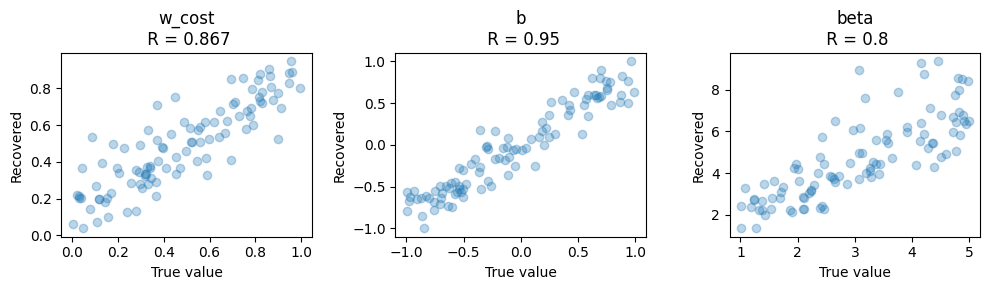

In [40]:
param_names = ['w_cost','b','beta']
n_cols = 3
n_rows = math.ceil(len(param_names)/n_cols)
fig,axes = plt.subplots(n_rows,n_cols,figsize=(10,3*n_rows))
axes = axes.flatten()
for i,name in enumerate(param_names):

    axes[i].scatter(param_rec_df[name+'_original'],param_rec_df[name+'_recovered'],alpha=0.3)
    pearson_r = np.corrcoef(param_rec_df[name+'_original'],param_rec_df[name+'_recovered'])[0,1]
    axes[i].set_xlabel('True value')
    axes[i].set_ylabel('Recovered')
    axes[i].set_title(name + '\n R = ' + str(np.round(pearson_r,3)))


plt.tight_layout()
plt.show()

## Method 2: 
sample parameters from the actual fitted distribution

In [ ]:
# method 2: using actual fitted parameters
params_all = model_fit_m3[['w_cost','b','beta']].values.tolist()

In [173]:
# Simulate data and refit using the model
n_sim = 10 # number of simulations
param_rec_avg = [] # average recovered parameter over simulations
for (data,param) in zip(data_model,params_all):
    data_sim = data[1]
    param_rec_all = []
    for sim in range(n_sim):
        choices,pred = genchoice_VBD_M3(param,data_sim)
        data_sim.loc[:,'Decision'] = choices
        param_rec, neg_llh = fit_model(data_sim,VBD_M3,[0.2,0,1],[(0, 1), (-1,1),(1e-5,10)])
        param_rec_all.append(param_rec)
    # calculate the average
    param_rec_avg.append(np.mean(param_rec_all,axis=0))

In [174]:
param_rec_avg = np.asarray(param_rec_avg)
param_rec_df = pd.DataFrame({
    'ID': data_decisions['PROLIFIC_PID'],
    'w_cost': param_rec_avg[:, 0],
    'b': param_rec_avg[:, 1],
    'beta': param_rec_avg[:, 2],
})

# param_rec_df.to_csv('output/Model/VBD_M3/param_recovery_realparam.csv',index=False)
param_rec_df.to_csv('output/Model/VBD_M3/param_recovery_sampledparam.csv',index=False)

In [23]:
# Save the recovered parameters, as the model fitting takes long time
param_rec_avg = np.asarray(param_rec_avg)
param_rec_df = pd.DataFrame({
    'ID': data_decisions['PROLIFIC_PID'],
    'w_self': param_rec_avg[:, 0],
    'w_loss': param_rec_avg[:, 1],
    'b': param_rec_avg[:, 2],
    'w_empathy': param_rec_avg[:, 3],
    'w_urgency': param_rec_avg[:, 4],
    'beta': param_rec_avg[:, 5],
})

param_rec_df.to_csv('output/Model/VBD_M1/param_recovery.csv',index=False)

Compare the recovered parameter and the actual parameter

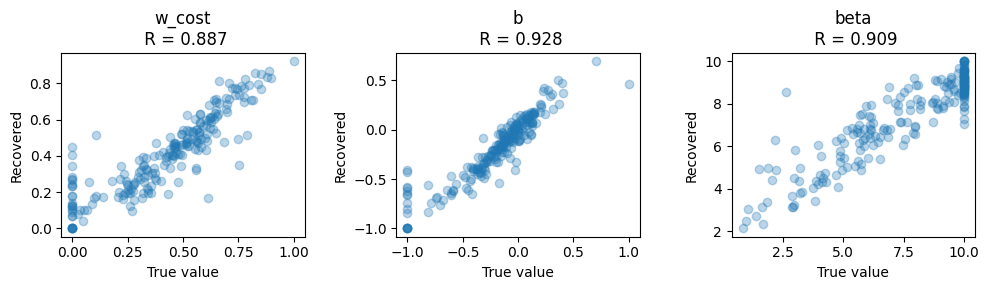

In [178]:
param_names = param_rec_df.columns[1:]
n_cols = 3
n_rows = math.ceil(len(param_names)/n_cols)
fig,axes = plt.subplots(n_rows,n_cols,figsize=(10,3*n_rows))
axes = axes.flatten()
for i,name in enumerate(param_names):
    axes[i].scatter(model_fit_m3[name],param_rec_df[name],alpha=0.3)
    pearson_r = np.corrcoef(model_fit_m3[name],param_rec_df[name])[0,1]
    axes[i].set_xlabel('True value')
    axes[i].set_ylabel('Recovered')
    axes[i].set_title(name + '\n R = ' + str(np.round(pearson_r,3)))

plt.tight_layout()
plt.show()